# Class Reconstruction
## Introduction
Classification is the problem of taking an unknown datum $\vec{x} \in \mathbb{R}^N$ and assigning it to a class label $c \in \mathcal{C}$, where $\mathcal{C}$ is the set of discrete class labels.  In this instance, $\vec{x}$ is assumed to exist in a high-dimensional feature space, though this is not a requirement.  If $\mathcal{C}$ is known in advance then this problem falls under the domain of supervised learning.  Now, there are [many ways](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to perform supervised learning but this notebook will focus on training a relatively simple neural network using PyTorch.

One way to view classification is as the non-linear projection of some high-dimensional space to a lower-dimensional one.  The projection is done in a way such that regions in the high-dimensional space are associated with a specific coordinate in the lower-dimensional space.  For example, if $\mathcal{C} = \{c_0, c_1, \dots, c_{L-1} \}$, where $L$ is the number of labels, then a vector in the "class space" can be $\vec{c}_0 = \begin{bmatrix} 1 & 0 & \dots & 0 \end{bmatrix}^T$, $\vec{c}_0 = \begin{bmatrix} 0 & 1 & \dots & 0 \end{bmatrix}^T$ and so on.  This is known as [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding, and maps an $N$-dimensional space to an $L$ dimensional one, where $L < N$.  The example provided below will use this type of encoding for classifying the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

Something that is lost with classification is the ability to go from a class label back to an *instance* of that class.  This is because this type of non-linear projection operation is not invertible.  There is no one-to-one mapping between a class instance and the class label; it is a many-to-one relationship.  However, there are networks that would support doing both.  Namely, a slightly modified autoencoder.  

## Script Setup
The constants below control how the training is done.  The parameters are batch size, number of epochs and an 'alpha' parameter used by the objective, or cost, function.

In [1]:
# Notebook Constants
BATCH_SIZE = 100
EPOCHS = 10
ALPHA = 0.5

The datasets are loaded using a utility `load_dataset` function.  This can load either the original MNIST dataset or the Fashion-MNIST dataset.

In [2]:
from utilities import load_dataset

# The Fashion-MNIST dataset can be loaded by changing 'mnist' to 'fashion'.
train, test = load_dataset('mnist', BATCH_SIZE)

print('Training Examples: %d' % (len(train)*BATCH_SIZE))
print('Testing Examples:  %d' % (len(test)*BATCH_SIZE))

Training Examples: 60000
Testing Examples:  10000


In [3]:
# Check to see if CUDA is available.
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Training with CUDA.')
else:
    device = torch.device('cpu')
    print('Training with CPU.')

Training with CPU.


## Network Design
The network is comprised of a classification frontend and a reconstruction backend.  It uses traditional linear units with sigmoidal activation functions.  The structure is
```
Input
  |
  V
 784 -> 256 -> 16 -> 10 -> 10 -> 16 -> 256 -> 784
                        |                      |
                        V                      V
                      Label              Reconstruction
                      
  |<--- Classifier --->| |<---- Generator ---->|
```

When provided with an input image (28x28 pixels), the network will produce a one-hot encoding of the particular class as well as a new, 28x28 pixel image of what the network believes the class looks like.  This being a feedforward network, it is possible to provide a label directly and obtain a representation of what the generator believes the label to look like.

In [4]:
from network import Reconstructor
model = Reconstructor().to(device)

## Training
The training loop is straightforward: loop over the dataset `EPOCH` times, randomly shuffling the dataset in `BATCH_SIZE` batches.  As discussed in the introduction, the purpose of this network is to both classify MNIST digits as well as to learn the digits from their classes.  As such, the cost function is defined as
\begin{equation}
    E\left( \vec{l}_p, \vec{x}_p \right) = (1 - \alpha)E_c(\vec{l}_p) + \alpha E_r(\vec{x}_p),
\end{equation}
where $E_c(\cdot)$ is the classification error and $E_r(\cdot)$ is the reconstruction error.  This cost function is designed so that it is the convex sum between these two errors.

Please note that, as the function has been written, the aggregate cost assumes that the magnitudes of $E_c(\cdot)$ and $E_r(\cdot)$ are similar.  I.e., their respective maximum values will be close to one another.  If they are not then it is possible for one of the costs to dominate the aggregate cost.

### Effect of $\alpha$
The $\alpha$ parameter switches the network between one of three modes.  When $\alpha = 0$, the network is trained to only be a classifier.  The output of the generator will be random noise because there is no cost associated with reconstructing the input images.  Conversely, when $\alpha = 1$, the network acts as an autoencoder.  The representation that it learns at the label output will depend on how the network is trained.  It will be able to recreate the input but it will not be able to classify anything.  Finally, if $\alpha > 0$ and $\alpha < 1$ then the network will be trained to do both.

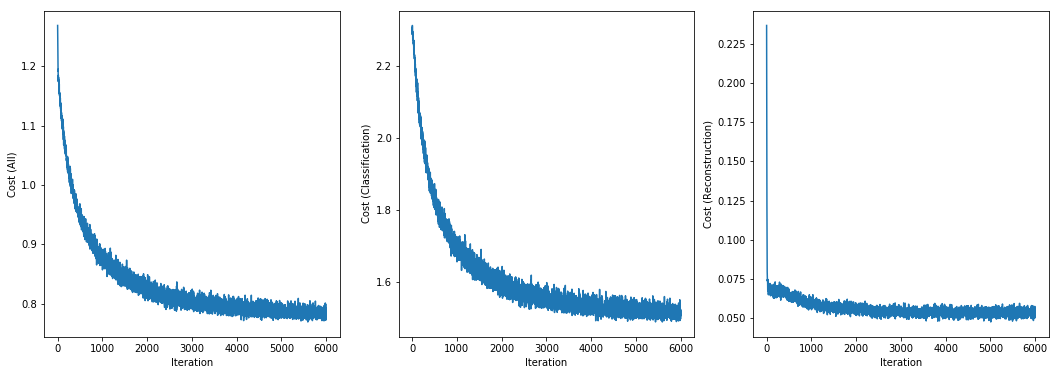

In [5]:
from tqdm import tqdm_notebook

optimizer = torch.optim.Adam(model.parameters())
loss_classification = torch.nn.CrossEntropyLoss()
loss_reconstruction = torch.nn.MSELoss()

def trange(count, desc):
    rng = range(count)
    return tqdm_notebook(rng, desc=desc, total=count)

losses_all = []
losses_cls = []
losses_rep = []

for epoch in trange(EPOCHS, 'Epoch'):
    for i, (img, lbl) in enumerate(train):
        img = img.reshape(-1, 28*28).to(device)
        lbl = lbl.to(device)

        # Compute the model's loss function.
        enc, rep = model(img)
        loss_cls = loss_classification(enc, lbl)
        loss_rep = loss_reconstruction(rep, img)
        loss = (1.0 - ALPHA)*loss_cls + ALPHA*loss_rep

        # Run the optimizer and update the model weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_all.append(loss.item())
        losses_cls.append(loss_cls.item())
        losses_rep.append(loss_rep.item())

# Plot the costs over time.
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(losses_all)
plt.xlabel('Iteration')
plt.ylabel('Cost (All)')

plt.subplot(1, 3, 2)
plt.plot(losses_cls)
plt.xlabel('Iteration')
plt.ylabel('Cost (Classification)')

plt.subplot(1, 3, 3)
plt.plot(losses_rep)
plt.xlabel('Iteration')
plt.ylabel('Cost (Reconstruction)')

plt.show()

## Network Outputs
While there is only one cost being optimized, the network has two outputs.  The first, the output of the classifier, can be assessed by looking at the test set.  This provides a measureable accuracy metric for the classifier.  The other output, the output of generator, is different.  

### Classifier Accuracy
The accuracy of the classifier is defined as
\begin{equation}
    \mathrm{Accuracy} = \frac{N_\mathrm{correct}}{N_\mathrm{total}} \times 100\%.
\end{equation}

In [6]:
# Compute the accuracy of the classifier.
with torch.no_grad():
    num_correct = 0
    num_total = 0
    for i, (img, lbl) in enumerate(test):
        img = img.reshape(-1, 28*28).to(device)
        lbl = lbl.to(device)

        out = model.classifier(img)
        _, prediction = torch.max(out.data, 1)
        num_total += lbl.shape[0]
        num_correct += (prediction == lbl).sum().item()

print('Accuracy: %g %% (%d/%d)' % (100.0*num_correct/num_total, num_correct, num_total))

Accuracy: 87.27 % (8727/10000)


### Generator Accuracy
The output of the generator is defined as the solution that minimizes the $L_2$-norm between a particular input label $\vec{c}_i$ and its associated input image $\vec{x}$.  As such, it is a bit more difficult to assign an accuracy metric that is meaningful in the same way that accuracy is.  In this case, it is possible to show what the network produces when given a particular label as a qualitative assessment.

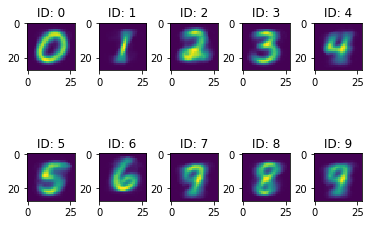

In [7]:
# Output what the network believes a label looks like.
import numpy as np
with torch.no_grad():
    fig, axs = plt.subplots(nrows=2, ncols=5)
    axes = axs.flatten()
    for i in range(10):
        enc = np.zeros((1, 10))
        enc[0, i] = 1

        enc = torch.tensor(enc, dtype=torch.float).to(device)
        out = model.generator(enc).reshape(28, 28)

        axes[i].imshow(out)
        axes[i].set_title('ID: %d' % i)

    fig.subplots_adjust(hspace=0.5, wspace=0.5)

## Conclusion
This notebook has shown how a simple feedfoward neural network can be used both for classification and sample generation.  This was accomplished using an autoencoder-style network and a specially-crafted cost function.  The cost function had a tuneable parameter, $\alpha$ that would allow the network to be be trained just for classification, reconstruction or a combination of both.  The purpose was not to create a state-of-the-art deep network but rather to demonstrate how a single network could be trained to perform multiple tasks.